In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from simpleRegression.utils import printMethodInfo, plot_data
from simpleRegression.fitFunctions import fittingFunction, SimpleRegression
from simpleRegression.LiEtAlFunction import (
    LiEtAlFunction,
    LiEtAlPlot,
    LiEtAlToNonDimGroups,
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import os
from alpine.data import Dataset
from SRScratch.SRScratch import SRScratch
from SRScratch.SRScratchUtils.sympyConversion import sympyConversion
import yaml

from matplotlib import rcParams

rcParams.update(
    {
        "font.family": "serif",  # or "DejaVu Serif"
        "mathtext.fontset": "cm",  # Use Computer Modern (LaTeX default)
        "mathtext.rm": "serif",
        "font.size": 12,
    }
)

# Loading data

In [2]:
# Load raw data
RawData = pd.read_csv("GetDataFromScratch/ScratchData/MaterialSweep/AllRawData.csv")
print(RawData.keys())
# Load Norm data
skip_bad_data = False
NormData = pd.read_csv(
    "GetDataFromScratch/ScratchData/MaterialSweep/NewNormData.csv",
    # "src/GetDataFromScratch/ScratchData/MaterialSweep/NormData.csv"
    # "src/GetDataFromScratch/ScratchData/MaterialSweep/ZhangData.csv"
    skiprows=(1, 2, 3, 4, 5) if skip_bad_data else None,
)
print(NormData.keys())
target_data_key = "Ft/Fn"
# target_data_key = "h_p/h_r"
# target_data_key = "H_s/E"

# Features and targets
features = np.array([NormData["syNorm"], NormData["n"]])
target = np.array(NormData[target_data_key])

if skip_bad_data:
    num_data = 39
else:
    num_data = 40

Index(['Yield Strength', 'Strain Hardening', 'Residual Depth', 'Width',
       'Pile-up Height', 'Normal Force', 'Tangential Force'],
      dtype='object')
Index(['syNorm', 'n', 'Ft/Fn', 'h_p/h_r', 'H_s/E'], dtype='object')


# Feature normalisation

In [3]:
norm_factor = "minmax"

# Feature normalisation
if norm_factor == "minmax":
    features_min = np.min(features, axis=1).reshape(-1, 1)
    feature_max = np.max(features, axis=1).reshape(-1, 1)
    features_norm = (features - features_min) / (feature_max - features_min)

    target_min = np.min(target)
    target_max = np.max(target)
    target_norm = (target - target_min) / (target_max - target_min)
elif norm_factor == "meanstd":
    features_mean = np.mean(features, axis=1).reshape(-1, 1)
    feature_std = np.std(features, axis=1).reshape(-1, 1)
    features_norm = (features - features_mean) / feature_std

    target_mean = np.mean(target)
    target_std = np.std(target)
    target_norm = (target - target_mean) / target_std
else:
    features_norm = features
    target_norm = target

random_seed = 42
X_train, X_test, y_train, y_test = train_test_split(
    features_norm.T, target_norm, test_size=0.2, random_state=random_seed
)

# Poly fitting

In [4]:
# Fitting polynomial
degrees = [2, 2]
use_interactions = True

best_params, r2_train_fitting, mse_train_fitting = SimpleRegression(
    features=X_train.T,
    target=y_train,
    degrees=degrees,
    use_interactions=use_interactions,
)
# print(best_params)
# print(f"R^2 train: {r2_train_fitting}", f"MSE train score: {mse_train_fitting}")

y_pred_test = fittingFunction(
    X_test.T,
    *best_params,
    degrees=degrees,
    include_interactions=use_interactions,
)

r2_test_fitting = r2_score(y_true=y_test, y_pred=y_pred_test)
# mse_test_fitting = mean_squared_error(y_true=y_test, y_pred=y_pred_test)
# print(f"R^2 test: {r2_test_fitting}", f"MSE test: {mse_test_fitting}")


y_pred_norm = fittingFunction(
    features_norm,
    *best_params,
    degrees=degrees,
    include_interactions=use_interactions,
)

if norm_factor == "minmax":
    y_pred = y_pred_norm * (target_max - target_min) + target_min
elif norm_factor == "meanstd":
    y_pred = y_pred_norm * target_std + target_mean
else:
    y_pred = y_pred_norm

# Poly fitting using sklearn

In [5]:
##### Using sklearn #####
from sklearn.linear_model import Lasso, Ridge, ElasticNet, ElasticNetCV

print("=" * 20)
print("Using sklearn")
poly = PolynomialFeatures(
    degree=2, include_bias=False, interaction_only=not use_interactions
)
X_poly = poly.fit_transform(X_train, y_train)

# regularisation
# model = LinearRegression() # no regularisation
# model = Lasso(alpha=0.1) # L1 norm
# model = Ridge(alpha=0.1)  # L2 norm
model = ElasticNetCV(
    n_alphas=100,
    l1_ratio=[0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    cv=3,
)  # mix of L1 and L2
# model = ElasticNet(alpha=0.00014, l1_ratio=0.7)
model.fit(X_poly, y_train)
print("Regularisation method: ", model.__class__.__name__)
print("alpha=", model.alpha_)
print("l1_ratio=", model.l1_ratio_)

# sklearn train and test scores

y_pred_sklearn_train = model.predict(poly.transform(X_train))
r2_train_sklearn = r2_score(y_train, y_pred_sklearn_train)
# mse_train_sklearn = mean_squared_error(y_train, y_pred_sklearn_train)
# print(f"R^2 train: {r2_train_sklearn}, MSE train: {mse_train_sklearn}")

y_pred_sklearn_test = model.predict(poly.transform(X_test))
r2_test_sklearn = r2_score(y_test, y_pred_sklearn_test)
# mse_test_sklearn = mean_squared_error(y_test, y_pred_sklearn_test)
print(f"R^2 train: {r2_train_sklearn}", f"R^2 test: {r2_test_sklearn}")

print("=" * 20)
print("poly fitting")
print(f"R^2 train: {r2_train_fitting}", f"R^2 test: {r2_test_fitting}")
print("=" * 20)


# Coefficients
print("Coefficients:")
all_sklearn_coeffs = np.append(model.intercept_, model.coef_)
print("sklearn best params: ", all_sklearn_coeffs)
print("custom func best params: ", best_params)

y_pred_sklearn_norm = model.predict(poly.transform(features_norm.T))
if norm_factor == "minmax":
    y_pred_sklearn = y_pred_sklearn_norm * (target_max - target_min) + target_min
elif norm_factor == "meanstd":
    y_pred_sklearn = y_pred_sklearn_norm * target_std + target_mean
else:
    y_pred_sklearn = y_pred_sklearn_norm

Using sklearn
Regularisation method:  ElasticNetCV
alpha= 0.00016744743586475034
l1_ratio= 1.0
R^2 train: 0.8197168499518005 R^2 test: 0.7163653485402569
poly fitting
R^2 train: 0.8201288651722063 R^2 test: 0.7160070475086566
Coefficients:
sklearn best params:  [ 0.79819174 -0.04641901  0.56159131 -0.01663419 -0.54230177 -0.56745336]
custom func best params:  [ 0.78969426 -0.04161895  0.60421973 -0.01495164 -0.60002806 -0.55773315]


# Plotting poly fit results

/tmp/ipykernel_201075/926671051.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(


(0.0, 0.0102)

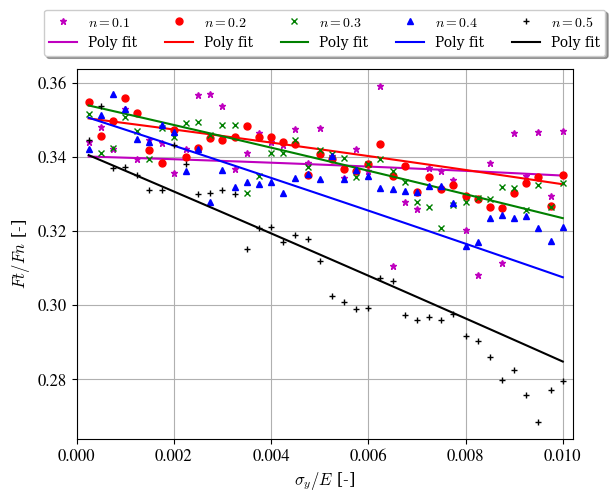

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
colors = ["m", "r", "g", "b", "k"]
shapes = ["*", "o", "x", "^", "+"]


for i in range(5):
    plt.plot(
        features[0, :].reshape(num_data, 5)[:, i],
        target.reshape(num_data, 5)[:, i],
        "o",
        markersize=5,
        color=colors[i],
        marker=shapes[i],
        label=rf"$n={np.array(NormData["n"]).reshape(num_data, 5)[0, i]}$",
    )
    plt.plot(
        features[0, :].reshape(num_data, 5)[:, i],
        y_pred.reshape(num_data, 5)[:, i],
        color=colors[i],
        label="Poly fit",
    )
    # plt.plot(
    #     features[0, :].reshape(num_data, 5)[:, i],
    #     y_pred_sklearn.reshape(num_data, 5)[:, i],
    #     "--",
    #     color=colors[i],
    #     label="sklearn",
    # )
# ax.set_xscale("log")
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.18),
    ncol=5,
    fancybox=True,
    shadow=True,
    fontsize="small",
)
# plt.xlabel(r"$\overline{\sigma_y/E}$ [-]")
# plt.ylabel(r"$\overline{" + target_data_key + "}$ [-]")
plt.xlabel(rf"$\sigma_y/E$ [-]")
plt.ylabel(rf"${target_data_key}$ [-]")
plt.grid()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontfamily("STIXGeneral")
# plt.ylim([0, 0.08])
plt.xlim([0, 0.0102])

# Li et al.

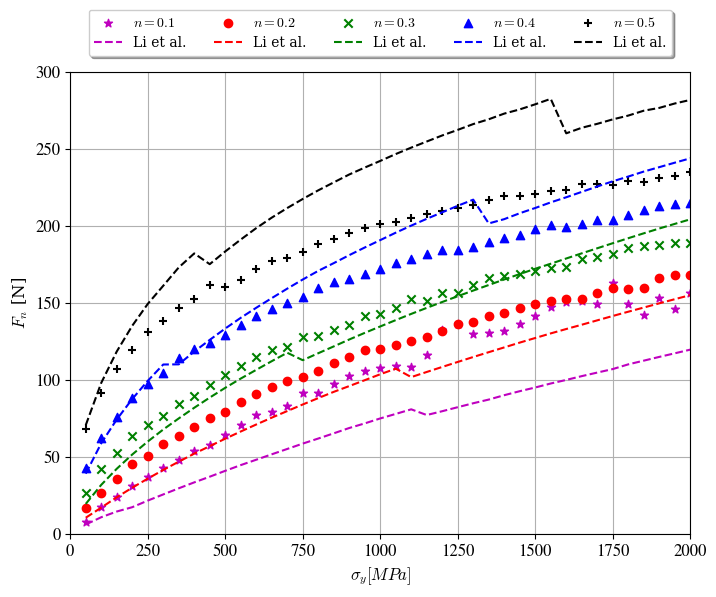

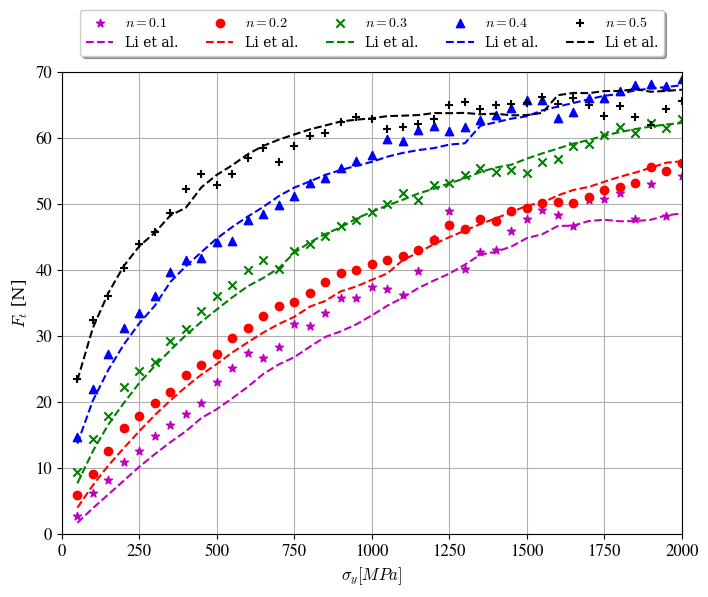

In [30]:
# ##### Using LiEtAl function #####

# Fn_r2_prev = 0
# Ft_r2_prev = 0

# for i in np.arange(0.5, 2, 0.05):
#     for j in np.arange(0.5, 2, 0.05):
#         for k in np.arange(0.5, 2, 0.05):

#             Fn, Ft = LiEtAlFunction(
#                 h_r=RawData["Residual Depth"],
#                 h_p=RawData["Pile-up Height"],
#                 w=RawData["Width"] / 2,
#                 sigma_y=RawData["Yield Strength"],
#                 n=RawData["Strain Hardening"],
#                 E=200000,
#                 mu=0.0,
#                 alpha=135.6 / 2,
#                 # alpha=180 / 2,
#                 k_1=i,
#                 k_2=j,
#                 k_n=k,
#             )
#             Fn_r2 = r2_score(Fn, RawData["Normal Force"])
#             Ft_r2 = r2_score(Ft, RawData["Tangential Force"])
#             if Fn_r2 + Ft_r2 > Fn_r2_prev + Ft_r2_prev:
#                 # if Fn_r2 > Fn_r2_prev:
#                 #     if Ft_r2 > Ft_r2_prev:
#                 print(
#                     f"Fn R2: {Fn_r2:.4f}, Ft R2: {Ft_r2:.4f}, k_1: {i}, k_2: {j}, k_n: {k}"
#                 )
#                 k_1_save = i
#                 k_2_save = j
#                 k_n_save = k
#                 Fn_r2_prev = Fn_r2
#                 Ft_r2_prev = Ft_r2

# print("Best k_1", k_1_save)
# print("Best k_2", k_2_save)
# print("Best k_n", k_n_save)
sy = np.array(RawData["Yield Strength"])
n = np.array(RawData["Strain Hardening"])

LiEtAl_Fn, LiEtAl_Ft = LiEtAlFunction(
    h_r=RawData["Residual Depth"],
    h_p=RawData["Pile-up Height"],
    w=RawData["Width"] / 2,
    sigma_y=RawData["Yield Strength"],
    n=RawData["Strain Hardening"],
    E=200000,
    mu=0.0,
    alpha=135.6 / 2,
    # alpha=180 / 2,
    # k_1=k_1_save,
    # k_2=k_2_save,
    # k_n=k_n_save,
    k_1=1.65,
    k_2=1.70,
    k_n=1.10,
)
# print("Best Fn R2", Fn_r2_prev)
# print("Best Ft R2", Ft_r2_prev)

targetForce = np.array(RawData["Normal Force"])
LiEtAlPlot(sy, n, np.array(LiEtAl_Fn), targetForce, ylabel="Fn")
targetForce = np.array(RawData["Tangential Force"])
LiEtAlPlot(sy, n, np.array(LiEtAl_Ft), targetForce, ylabel="Ft")

# convert LiEtAl function to non-dim groups
LiEtAl_HsE, LiEtAt_FtFn = LiEtAlToNonDimGroups(
    Fn=np.array(LiEtAl_Fn),
    Ft=np.array(LiEtAl_Ft),
    w=np.array(RawData["Width"]),
    E=200000,
)

# Symbolic regression

## Load data

In [8]:
# NormData = pd.read_csv("GetDataFromScratch/ScratchData/MaterialSweep/NewNormData.csv")


yamlfile = "main.yaml"
# filename = os.path.join(os.path.dirname(yamlfile), yamlfile)
with open(yamlfile) as config_file:
    config_file_data = yaml.safe_load(config_file)

train_data = Dataset("dataset", X_train, y_train)
test_data = Dataset("dataset", X_test, y_test)
train_data.X = [train_data.X[:, i] for i in range(X_train.shape[1])]
test_data.X = [test_data.X[:, i] for i in range(X_train.shape[1])]

## Run SR

In [9]:
best_ind, fit_score, train_pred, test_pred = SRScratch(
    config_file_data=config_file_data,
    trainDataSet=train_data,
    testDataSet=test_data,
    seed=[
        "add(a,add(add(add(mul(a, x1), mul(a, x2)), add(mul(a, square(x1)), mul(a, square(x2))))), mul(a, mul(x1, x2)))"
    ],
)
sC = sympyConversion(tree=best_ind, best_ind_consts=best_ind.consts)
simple_str = sC.simplify_expr()
print(simple_str)
MSE_train_SR = mean_squared_error(y_train, train_pred)
r2_train_SR = r2_score(y_train, train_pred)
MSE_test_SR = mean_squared_error(y_test, test_pred)
r2_test_SR = r2_score(y_test, test_pred)
print("mse on test data:", MSE_test_SR)
print("r2 on test data:", r2_test_SR)

2025-05-23 13:40:28,948	INFO worker.py:1852 -- Started a local Ray instance.


Generating initial population(s)...
DONE.
Seeding population with individuals...
 -= START OF EVOLUTION =- 
Evaluating initial population(s)...
DONE.
   	     	           fitness           	             size             
   	     	-----------------------------	------------------------------
gen	evals	min   	avg   	max   	std  	min	avg  	max	std   
1  	1824 	0.0084	0.1707	0.5272	0.147	2  	7.039	43 	4.5665
Best individuals of this generation:
exp(add(add(x2, a), mul(x2, sub(mul(square(sub(x2, a)), a), x1))))
2  	1808 	0.0084	0.0373	0.072 	0.011	2  	6.479	37 	4.0593
Best individuals of this generation:
exp(add(add(x2, a), mul(x2, sub(mul(square(sub(x2, a)), a), x1))))
3  	1801 	0.0075	0.0296	0.0345	0.0059	2  	6.88 	24 	4.2361
Best individuals of this generation:
sin(sub(a, mul(x2, mul(x2, x1))))
4  	1780 	0.0075	0.025 	0.0337	0.0056	4  	9.2085	24 	4.1795
Best individuals of this generation:
sin(sub(a, mul(x2, mul(x2, x1))))
5  	1801 	0.0075	0.0211	0.0264	0.0046	4  	10.101	27 	4.0342
Best 

In [10]:
str(simple_str)

'-0.12213933345418886*exp(x1 + 0.54753056363462201*x2**2) + cos(x1*x2**7)'

## Plot result

In [ ]:
if 0:
    simple_str = "-0.2174*x1*(2*x2**8 + x2 + 0.5392) + 0.8555"

In [22]:
from sympy import lambdify
from sympy import *

x1, x2 = symbols("x1 x2")
# h = -0.0197*x1*(2*x2**8 + x2 + 0.5392) + 0.3460
# print((h-target_min)/(target_max-target_min))
f = lambdify([x1, x2], simple_str, "numpy")

sr_pred_norm = f(features_norm[0, :], features_norm[1, :])
if norm_factor == "minmax":
    sr_pred = sr_pred_norm * (target_max - target_min) + target_min
elif norm_factor == "meanstd":
    sr_pred = sr_pred_norm * target_std + target_mean
else:
    sr_pred = sr_pred_norm

(0.0, 0.0102)

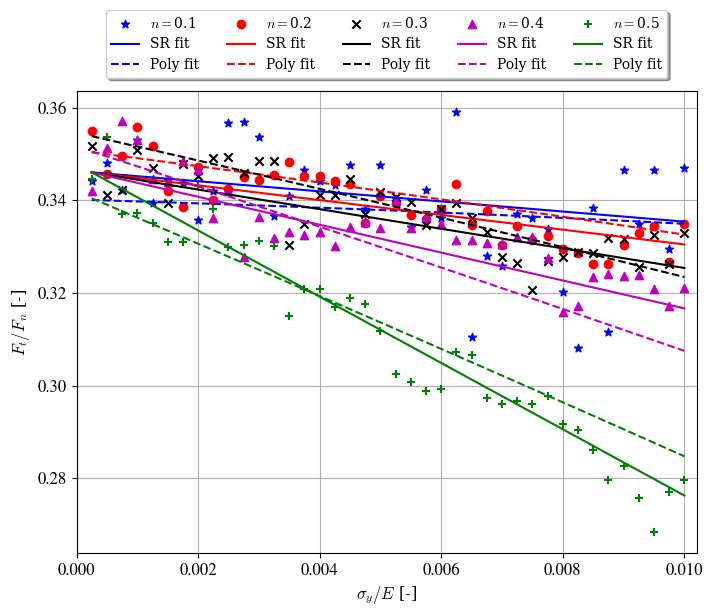

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
color = ["b", "r", "k", "m", "g"]
shapes = ["*", "o", "x", "^", "+"]
for i in range(5):
    plt.scatter(
        features[0, :].reshape(num_data, 5)[:, i],
        target.reshape(num_data, 5)[:, i],
        # markersize=5,
        color=color[i],
        marker=shapes[i],
        label=rf"$n=${np.array(NormData["n"]).reshape(num_data, 5)[0, i]}",
    )
    plt.plot(
        features[0, :].reshape(num_data, 5)[:, i],
        sr_pred.reshape(num_data, 5)[:, i],
        color=color[i],
        label="SR fit",
    )
    plt.plot(
        features[0, :].reshape(num_data, 5)[:, i],
        y_pred.reshape(num_data, 5)[:, i],
        "--",
        color=color[i],
        label="Poly fit",
    )
    # if target_data_key == "Ft/Fn":
    #     plt.plot(
    #         features[0, :].reshape(num_data, 5)[:, i],
    #         LiEtAt_FtFn[:, i],
    #         "-.",
    #         color=color[i],
    #         label="Li et al. prediction",
    #     )
    # elif target_data_key == "H_s/E":
    #     plt.plot(
    #         features[0, :].reshape(num_data, 5)[:, i],
    #         LiEtAl_HsE[:, i],
    #         "-.",
    #         color=color[i],
    #         label="Li et al.",
    #     )
# ax.set_xscale("log")
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.19),
    ncol=5,
    fancybox=True,
    shadow=True,
    fontsize="small",
)
# plt.xlabel(r"$\overline{\sigma_y/E}$ [-]")
# plt.ylabel(r"$\overline{" + target_data_key + "}$ [-]")
plt.xlabel(rf"$\sigma_y/E$ [-]")
plt.ylabel(rf"${target_data_key}$ [-]")
plt.grid()
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontfamily("STIXGeneral")
ax.set_axisbelow(True)

# plt.ylim([0.2, 0.4])
plt.xlim([0, 0.0102])

# Comparing SR and Fitting

In [13]:
print("Poly fitting r2 train:", r2_train_fitting, " r2 test:", r2_test_fitting)
print("SR r2 train:", r2_train_SR, "r2 test:", r2_test_SR)

Poly fitting r2 train: 0.8201288651722063  r2 test: 0.7160070475086566
SR r2 train: 0.8722203633959482 r2 test: 0.7600655267296755
